# WSI 2022L
# Laboratorium 7 (Bayes)
# Michał Brus, 299106

# Importy

In [7]:
import scipy.stats as st
import statistics as stat
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Klasa NaiveBayesClassifier

In [8]:
# noinspection PyUnresolvedReferences
class NaiveBayesClassifier:
    def __init__(self, dataset, target_names, n_splits):
        self.dataset = dataset
        self.n_splits = n_splits
        self.folds = self.make_n_splits()
        self.target_names = target_names

    def class_probabilities(self, stats, row):
        total_rows = sum([stats[label][0][2] for label in stats])
        probabilities = {}
        for class_value, class_stats in stats.items():
            probabilities[class_value] = stats[class_value][0][2] / total_rows
            for i in range(len(class_stats)):
                mean, stdev, count = class_stats[i]
                probabilities[class_value] *= st.norm(mean, stdev).pdf(row[i])
        return probabilities

    def class_statistics(self, dataset):
        separated = self.separate_by_class(dataset)
        stats = {}
        for class_value, rows in separated.items():
            stats[class_value] = self.make_statistics(rows)
        return stats

    def separate_by_class(self, dataset):
        separated = {}
        for i in range(len(dataset)):
            vector = dataset.iloc[i]
            class_value = vector[-1]
            if class_value not in separated:
                separated[class_value] = []
            separated[class_value].append(vector)
        return separated

    def make_statistics(self, dataset):
        stats = [(stat.mean(column), stat.stdev(column), len(column)) for column in zip(*dataset)]
        stats = stats[:-1]
        return stats

    def check_accuracy(self, actual, predicted):
        correct = 0
        for i in range(len(actual)):
            if actual[i] == predicted[i]:
                correct += 1
        return correct / len(actual) * 100.0

    def make_n_splits(self):
        splits = []
        kf = KFold(n_splits=self.n_splits, shuffle=True)
        for train_index, test_index in kf.split(self.dataset):
            x_train, x_test = self.dataset.iloc[train_index], self.dataset.iloc[test_index]
            splits.append((x_train, x_test))
        return splits

    def predict(self, stats, row):
        probabilities = self.class_probabilities(stats, row)
        best_label, best_prob = None, -1
        for class_value, probability in probabilities.items():
            if best_label is None or probability > best_prob:
                best_prob = probability
                best_label = class_value
        return best_label

    def run(self, train_set, test_set):
        stats = self.class_statistics(train_set)
        predictions = []
        for i, row in test_set.iterrows():
            predicted = self.predict(stats, row)
            predictions.append(predicted)
        return predictions

    def evaluate(self):
        scores = []
        matrices = []
        for fold in self.folds:
            train_set = fold[0]
            test_set = fold[1]
            predicted = self.run(train_set, test_set)
            actual = [row[-1] for i, row in test_set.iterrows()]
            accuracy = self.check_accuracy(actual, predicted)
            conf_matrix = confusion_matrix(actual, predicted, normalize='true')
            scores.append(accuracy)
            matrices.append(conf_matrix)
        return scores, matrices

    def test(self):
        scores, conf_matrices = self.evaluate()
        self.display_conf_matrix(conf_matrices)
        print(f"Accuracy in separate folds: {scores}")
        print(f"Mean accuracy: {sum(scores) / len(scores)}%")

    def display_conf_matrix(self, matrices):

        for i, matrix in enumerate(matrices):
            display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=self.target_names)
            display.plot(cmap=plt.cm.Blues)
            display.ax_.set_title(f"Fold no. {i}")
        plt.show()

    def find_prediction(self, row):
        label = self.predict(self.class_statistics(self.dataset), row)
        print(f"Data: {row} -> Prediction: {label}")


# Funkcja testująca działanie klasyfikatora

In [9]:
def test():
    iris = datasets.load_iris()
    df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
    df['target'] = iris.target
    classifier = NaiveBayesClassifier(df, iris.target_names, 5)
    classifier.test()
    classifier.find_prediction([4, 2, 5, 1])

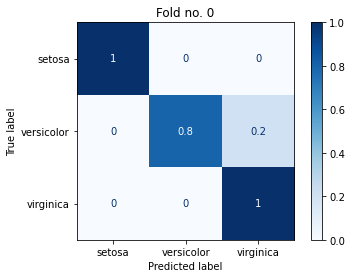

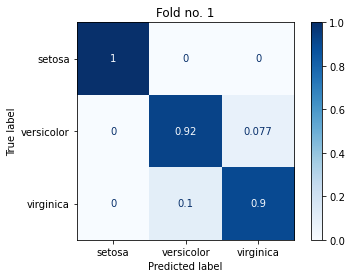

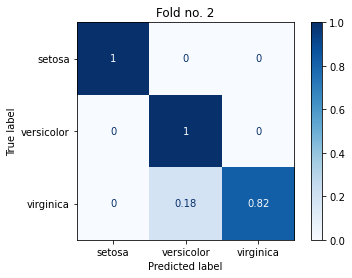

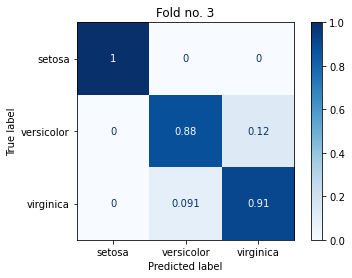

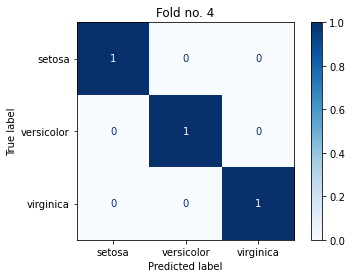

Accuracy in separate folds: [93.33333333333333, 93.33333333333333, 93.33333333333333, 93.33333333333333, 100.0]
Mean accuracy: 94.66666666666666%
Data: [4, 2, 5, 1] -> Prediction: 1.0


In [10]:
test()